In [427]:
%%capture
# Imports
import os

import pandas as pd
from matplotlib.ticker import PercentFormatter, ScalarFormatter
from matplotlib import pyplot as plt

import weightedcalcs

from switch_model.tools.graph.main import GraphTools, Scenario

X_LABEL = "Wind-to-Solar Share"

# Define folders
rel_path_base = "../../../../switch_runs/ldes_runs"
output_file_name="Figure 3"
root_path = os.path.normpath(os.path.join(os.getcwd(), rel_path_base))
graph_dir=os.path.join(root_path,"LDES_paper_graphs")
output_path=os.path.join(graph_dir, output_file_name)
get_rel_path = lambda ext: os.path.join(rel_path_base, ext)

# Define scenarios
scenario_mapping = {0.0909: "WS10", 0.187: "1342", .5: "WS100", 0.833 : "WS500" }
baseline = 0.187
scenarios = [Scenario(get_rel_path(p), name=n) for (n, p) in scenario_mapping.items()]

# Prepare graph tools
tools = GraphTools(scenarios=scenarios, graph_dir=graph_dir)
tools.pre_graphing(multi_scenario=True, name=output_file_name)

# Specify formatting and get figure
plt.rcParams['font.family'] = 'sans-serif'
figure_size = (12, 12)
fig = tools.get_figure(size=figure_size)

# Define save() function to use in charts
def save():
    fig.savefig(output_path, bbox_inches="tight")
    print("Saved figure to " + output_path)
    return fig

def set_x_axis(ax):
    ax.set_xlabel(X_LABEL)
    ax.set_xticks([0.2,0.5,0.8])
    ax.set_xticks([0.1,0.2,0.3,0.4,0.6,0.7,0.8], minor=True)
    ax.set_xticklabels(["80%\nSolar", "50/50 Wind-Solar", "80%\nWind"]) 
    ax.axvline(baseline, linestyle="dotted")
    ax.set_xlim([0.08,0.86]) 
    
def remove_y_ticks(ax):
    ax.set_yticklabels([])
#     ax.get_yaxis().set_visible(False)
    
def set_tx_right_axis(ax):
    ax.set_ylim(0, 12e7)
    
def set_capacity_ax(ax):
    ax.set_ylim(0, 600)
    
def set_duration_ax(ax):
    ax.set_ylim(1, 900)
    
storage_ticks = [4, 10, 50, 100, 500]

# Define axes
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)#, sharey=ax1)
ax3 = fig.add_subplot(2, 2, 3, sharex=ax1)
ax4 = fig.add_subplot(2, 2, 4, sharex=ax2)#, sharey=ax3)
rax1 = ax1.twinx()
rax2 = ax2.twinx()
plt.subplots_adjust(wspace=0.01, hspace=0.01)

Saved figure to /data/home/machstg/switch_runs/ldes_runs/LDES_paper_graphs/Figure 3


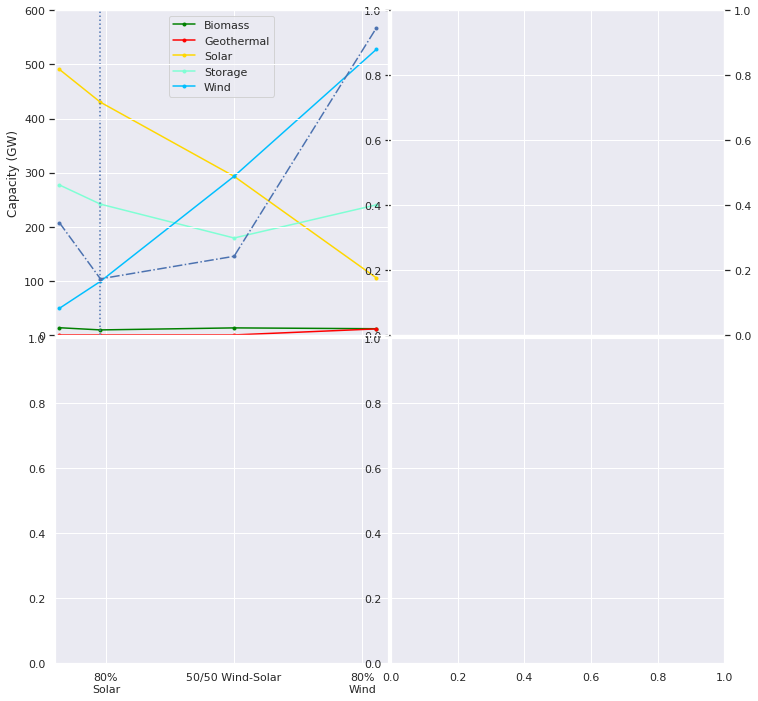

In [428]:
ax = ax1
rax = rax1
ax.clear()
rax.clear()    
ax.tick_params(top=False, bottom=False, right=False, left=True, which="major")
ax.tick_params(top=False, bottom=False, right=False, left=False, which="minor")
rax.tick_params(top=False, bottom=False, right=False, left=False, which="both")

def plot_change(ax, rax):
    # Calculate transmission
    tx = tools.get_dataframe("transmission.csv", usecols=["BuildTx", "trans_length_km", "scenario_name"], convert_dot_to_na=True).fillna(0)
    tx["BuildTx"] *= tx["trans_length_km"]
    # tx["BuildTx"] *= 1e-3
    tx = tx.groupby("scenario_name", as_index=False)["BuildTx"].sum().set_index("scenario_name")
    tx = tx.rename({"BuildTx": "New Tx"}, axis=1)
    tx.plot(ax=rax, marker=".", linestyle="dashdot", legend=False)
    set_tx_right_axis(rax)

    df = tools.get_dataframe("gen_cap.csv")
    df = tools.transform.gen_type(df)
    df = df.groupby(["scenario_name", "gen_type"], as_index=False)["GenCapacity"].sum()
    df = df.pivot(columns="gen_type", index="scenario_name", values="GenCapacity")
    df *= 1e-3 # Convert to GW
    df = df.rename_axis("Technology", axis=1).rename_axis("Scenario")
    # Remove zero columns
    s = df.std()
    df = df[[c for c in df.columns if c not in s[s==0]]]
    # df -= df.loc[0.23] # Make it as change compared to baseline
    
    df.plot(ax=ax, color=tools.get_colors(), marker=".", legend=False)

plot_change(ax, rax)
set_x_axis(ax)
remove_y_ticks(rax)
set_capacity_ax(ax)
ax.legend()
ax.set_ylabel("Capacity (GW)")
save()
# storage
# tx

Saved figure to /data/home/machstg/switch_runs/ldes_runs/LDES_paper_graphs/Figure 3


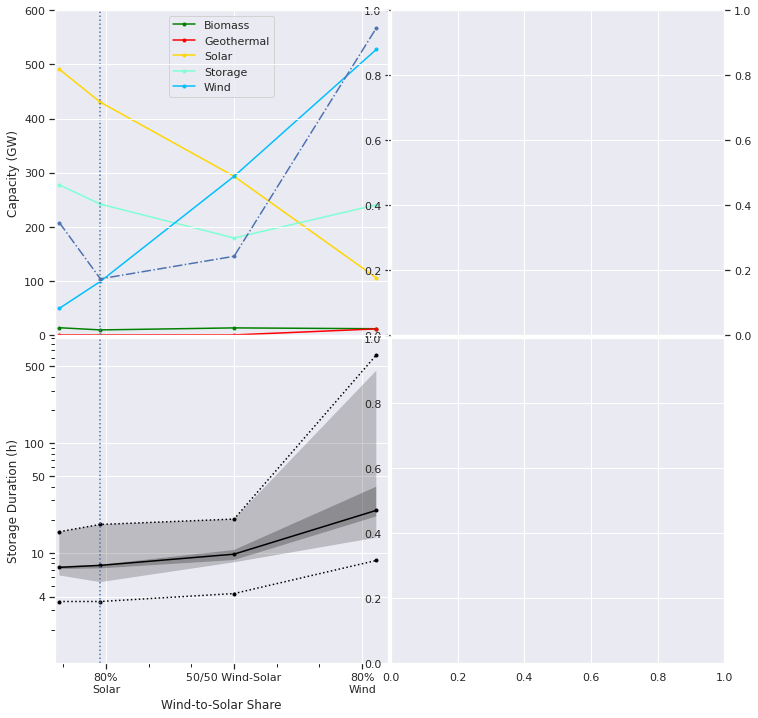

In [429]:
ax = ax3
ax.clear()
ax.tick_params(top=False, bottom=True, right=False, left=True, which="both")
def plot_storage(ax):
    storage = tools.get_dataframe("storage_capacity.csv")
    storage = storage[storage["OnlinePowerCapacityMW"] != 0]
    storage["duration"] = storage["OnlineEnergyCapacityMWh"] / storage["OnlinePowerCapacityMW"]
    # storage["duration_group"] = pd.cut(storage["duration"], [0,  10, float("inf")], labels=["<10h storage", "10+h storage"])
    storage = storage[["scenario_name", "duration", "OnlinePowerCapacityMW"]]
    storage_group = storage.groupby(["scenario_name"])
    calc = weightedcalcs.Calculator("OnlinePowerCapacityMW")
    
#     mean = storage_group.mean().rename("mean_val")
    inner_quartile = 0.25
    quartile = 0.05
    median = calc.quantile(storage_group, "duration", 0.5).rename("median_val")
    lower_inner = calc.quantile(storage_group, "duration", inner_quartile).rename("lower_inner")
    upper_inner = calc.quantile(storage_group, "duration", 1 - inner_quartile).rename("upper_inner")
    lower = calc.quantile(storage_group, "duration", quartile).rename("lower")
    upper = calc.quantile(storage_group, "duration", 1 - quartile).rename("upper")
    maxi = storage_group["duration"].max().rename("max")
    mini = storage_group["duration"].min().rename("min")
    df = pd.concat([mini, lower, lower_inner, median, upper_inner, upper, maxi], axis=1)

    x = df.index.values
    ax.plot(x, df["max"].values, color="black", linestyle="dotted", marker=".", label="Min/Max")
    ax.plot(x, df["min"].values, color="black", linestyle="dotted", marker=".")
    ax.plot(x, df.median_val.values, color="black", label="Median", marker=".")
    ax.fill_between(x, df.upper_inner.values, df["upper"].values, alpha=0.2, color="black", edgecolor=None,
                    label=f"{int(quartile * 100)}-{int(100 - quartile * 100)}th percentile")
    ax.fill_between(x, df["lower"].values, df.lower_inner.values, alpha=0.2, color="black", edgecolor=None)
    ax.fill_between(x, df.lower_inner.values, df.upper_inner.values, alpha=0.4, color="black", edgecolor=None,
                    label=f"{int(quartile_inner * 100)}-{int(100 - quartile_inner * 100)}th percentile")
    set_duration_ax(ax)
    ax.set_yscale('log')
r = plot_storage(ax)
ax.set_ylabel(u"Storage Duration (h)")
ax.set_yticks(storage_ticks)

ax.yaxis.set_major_formatter(ScalarFormatter())
set_x_axis(ax)

save()

In [430]:
# Define scenarios
scenario_mapping = {0: "H25", .5: "H26", 1: "1342" }
scenarios = [Scenario(get_rel_path(p), name=n) for (n, p) in scenario_mapping.items()]

# Prepare graph tools
tools = GraphTools(scenarios=scenarios, graph_dir=graph_dir)
tools.pre_graphing(multi_scenario=True, name=output_file_name)

def set_x_axis(ax):
    ax.set_xlabel("Hydropower Reduction")
    ax.set_xticks([0,0.5,1])
    ax.set_xticks([0.1,0.2,0.3,0.4,0.6,0.7,0.8, 0.9], minor=True)
    ax.set_xticklabels(["No\nhydro", "50% of baseline", "Baseline"]) 

Saved figure to /data/home/machstg/switch_runs/ldes_runs/LDES_paper_graphs/Figure 3


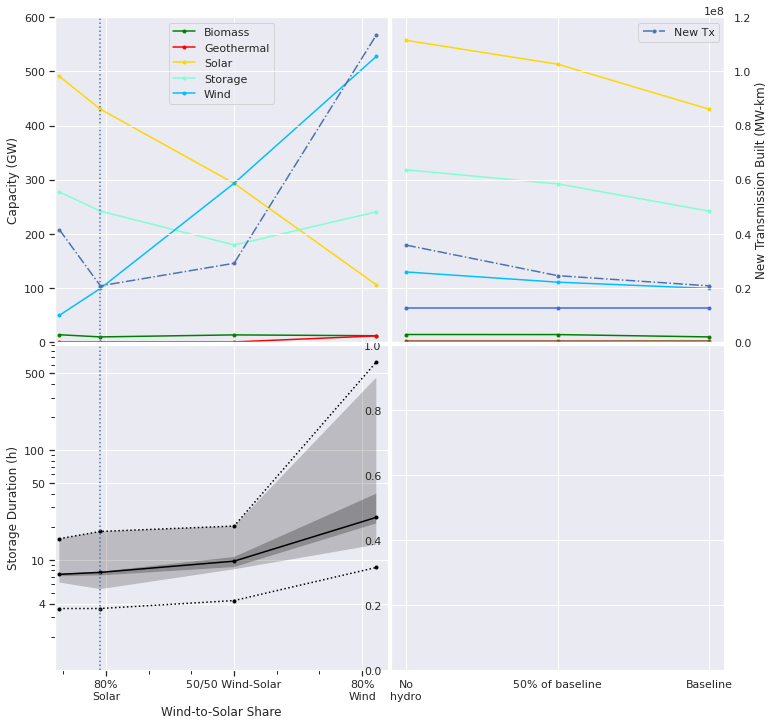

In [431]:
ax = ax2
rax = rax2
ax.clear()
rax.clear()    
ax.tick_params(top=False, bottom=False, right=False, left=False, which="both")
rax.yaxis.set_label_position("right")
rax.yaxis.tick_right()
rax.tick_params(top=False, bottom=False, right=False, left=False, which="both")
rax.set_ylabel("New Transmission Built (MW-km)")
plot_change(ax, rax)
set_capacity_ax(ax)
set_x_axis(ax)
remove_y_ticks(ax)
rax.legend()
save()
# storage
# tx

Saved figure to /data/home/machstg/switch_runs/ldes_runs/LDES_paper_graphs/Figure 3


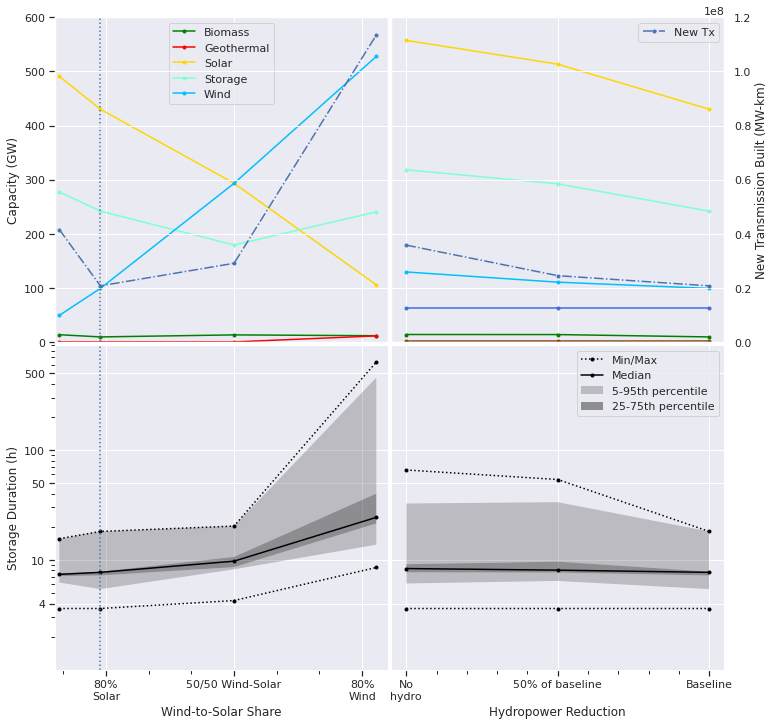

In [432]:
ax = ax4
ax.clear()
ax.tick_params(top=False, bottom=True, right=False, left=False, which="both")
plot_storage(ax)
remove_y_ticks(ax)
set_x_axis(ax)
ax.set_yticks(storage_ticks)
ax.legend()

save()